# Lab 3: Multiclass Classification with XGBoost

In [1]:
## Notebook Settings
# Add autotime of each block
!pip install ipython-autotime
%load_ext autotime

### Goals:
- Learn the basics of cyber network data with respect to consumer IoT devices
- Load network data into Pandas and a GDF (for comparison)
- Explore network data and features
- Use XGBoost to build a classification model
- Evaluate the model

This lab builds on the previous labs and will utilize some of those skills.

### Background

#### The Internet of Things and Data at a Massive Scale

Gartner estimates there are currently over 8.4 billion Internet of Things (IoT) devices. By 2020, that number is [estimated to surpass 20 billion](https://www.zdnet.com/article/iot-devices-will-outnumber-the-worlds-population-this-year-for-the-first-time/). These types of devices range from consumer devices (e.g., Amazon Echo, smart TVs, smart cameras, door bells) to commercial devices (e.g., building automation systems, keycard entry). All of these devices exhibit behavior on the Internet as they communicate back with their own clouds and user-specified integrations.

#### Types of Network Data

The most detailed type of data that is typically collected on a network is full Packet CAPture (PCAP) data. This information is detailed and contains everything about the communication, including: source address, destination address, protocols used, bytes transferred, and even the raw data (e.g., image, audio file, executable). PCAP data is fine-grained, meaning that there is a record for each frame being transmitted. A typical communication is composed of many individual packets/frames.

If we aggregate PCAP data so that there is one row of data per communication session, we call that flow level data. A simplified example of this relationship is shown in the figure below.

![PCAP_flow_relationship](pcap_vs_flow.png)

For this tutorial, we use data from the University of New South Wales. In a lab environment, they [collected nearly three weeks of IoT data from 21 IoT devices](http://149.171.189.1). They also kept a detailed [list of devices by MAC address](http://149.171.189.1/resources/List_Of_Devices.txt), so we have ground-truth with respect to each IoT device's behavior on the network.

**Our goal is to utilize the behavior exhibited in the network data to classify IoT devices.**

### Data Investigation

Let's first see some of the data. We'll load a PCAP file in using PyShark (a Python wrapper for Tshark).

In [2]:
import pyshark
cap = pyshark.FileCapture("/cwshare/unsw_iot/16-09-27.pcap")

time: 37.3 ms


In [3]:
print(cap[0])

Packet (Length: 156)
Layer ETH:
	Source: 30:8c:fb:2f:e4:b2
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	Type: IPv4 (0x0800)
	Destination: 14:cc:20:51:33:ea
	Address: 14:cc:20:51:33:ea
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	.... ..0. .... .... .... .... = LG bit: Globally unique address (factory default)
	Address: 30:8c:fb:2f:e4:b2
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
Layer IP:
	Source GeoIP: Unknown
	Identification: 0xd29e (53918)
	Protocol: TCP (6)
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Header checksum: 0x7fc2 [validation disabled]
	Total Length: 142
	0000 00.. = Differentiated Services Codepoint: Default (0)
	Destination GeoIP Longitude: -77.483803
	Header checksum status: Unverified
	.... 0101 = Header Length: 20 bytes (5)
	.1.. .... = Don't fragment: Set
	Destination GeoIP City: Ashburn, VA
	0... .... = Reserved bit: Not set
	Destination Geo

In [15]:
print(cap[0].ip)

Layer IP:
	Source GeoIP: Unknown
	Total Length: 142
	Source: 192.168.1.106
	Identification: 0xd29e (53918)
	Header checksum: 0x7fc2 [validation disabled]
	Time to live: 64
	Flags: 0x02 (Don't Fragment)
	Destination GeoIP Country: United States
	0000 00.. = Differentiated Services Codepoint: Default (0)
	Destination GeoIP AS Number: AS14618 Amazon.com, Inc.
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Fragment offset: 0
	0... .... = Reserved bit: Not set
	.1.. .... = Don't fragment: Set
	Protocol: TCP (6)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	.... 0101 = Header Length: 20 bytes (5)
	Destination: 52.87.241.159
	..0. .... = More fragments: Not set
	Destination GeoIP Latitude: 39.033501
	Destination GeoIP Longitude: -77.483803
	0100 .... = Version: 4
	Header checksum status: Unverified
	Destination GeoIP City: Ashburn, VA
	Destination GeoIP: Ashburn, VA, United States, AS14618 Amazon.com, Inc., 39.033501, -77.483803

time: 1.2 ms


There's really a lot of features there! In addition to having multiple layers (which may differ between packets), there are a number of other issues with working directly with PCAP. Often the payload is encrypted (note the SSL layer in the above example), rendering it useless. The lack of aggregation also makes it difficult to differentiate between packets. What we really care about for this application is what a *session* looks like. In other words, how a Roku interacts with the network is likely quite different than how a Google Home interacts. 

To save time for the tutorial, all three weeks of PCAP data have already been transformed to flow data, and we can load that in to a typical Pandas dataframe. Due to how the data was created, we have a header row (with column names) as well as a footer row. We want to use the header but will skip the footer.

In [4]:
import pandas as pd
pdf = pd.read_csv("/cwshare/unsw_iot/bro/conn.log", sep='\t', skipfooter=1)
print("==> pdf shape: ",pdf.shape)

/opt/conda/envs/pygdf_dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


==> pdf shape:  (950384, 23)
time: 12.2 s


We can look at what this new aggregated data looks like, and get a better sense of the columns and their data types.

In [3]:
pdf.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,orig_l2_addr,resp_l2_addr
0,1.474553e+09,CIlOTU4kRBDOEJ2zf,192.168.1.241,61725,192.168.1.1,53,udp,dns,-,-,...,-,0,Dc,1,74,0,0,-,70:ee:50:18:34:43,14:cc:20:51:33:ea
1,1.474553e+09,CmV0US1aCCPzrVRz36,192.168.1.193,4425,192.168.1.223,49153,tcp,http,0.008820,196,...,-,0,ShADadfF,5,464,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
2,1.474553e+09,CEXvDL2UPDYnBDtd6h,192.168.1.193,4426,192.168.1.223,49153,tcp,http,0.008664,198,...,-,0,ShADadfF,5,466,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
3,1.474553e+09,CEXDAD42Irgl4M5go8,192.168.1.193,4977,192.168.1.249,49152,tcp,http,0.020995,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88
4,1.474553e+09,CW1YbA2fZzHrztJ0rl,192.168.1.193,4978,192.168.1.249,49152,tcp,http,0.018730,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88


time: 30.3 ms


In [4]:
pdf.dtypes

ts                float64
uid                object
id.orig_h          object
id.orig_p           int64
id.resp_h          object
id.resp_p           int64
proto              object
service            object
duration           object
orig_bytes         object
resp_bytes         object
conn_state         object
local_orig         object
local_resp         object
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents     object
orig_l2_addr       object
resp_l2_addr       object
dtype: object

time: 2.91 ms


In [5]:
# maybe we rename the columns

time: 407 µs


In [18]:
labels_pdf = pd.read_csv("/cyshare/KDD2018/lab_mac_labels.csv", sep=',')

time: 2.37 ms


In [19]:
labels_pdf.head()

,Device,MAC,Connection,Category
0,Smart Things,d0:52:a8:00:67:5e,Wired,Hub
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,Speaker
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,Camera
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera


time: 8.5 ms


In [20]:
labels_pdf = labels_pdf.assign(CategoryID=(labels_pdf['Category']).astype('category').cat.codes)

time: 2.1 ms


In [21]:
labels_pdf.head()

,Device,MAC,Connection,Category,CategoryID
0,Smart Things,d0:52:a8:00:67:5e,Wired,Hub,6
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,Speaker,11
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera,1
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,Camera,1
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1


time: 9.04 ms


In [25]:
merged_pdf = pd.merge(pdf,labels_pdf, how='left', left_on=['orig_l2_addr'], right_on=['MAC'])

time: 621 ms


In [31]:
merged_pdf = merged_pdf.rename(columns = {'Device':'orig_device',
                                          'MAC':'orig_MAC',
                                          'Connection':'orig_connection',
                                          'Category':'orig_category',
                                          'CategoryID':'orig_category_id'})

time: 424 ms


In [32]:
merged_pdf = pd.merge(merged_pdf,labels_pdf, how='left', left_on=['resp_l2_addr'], right_on=['MAC'])

time: 890 ms


In [34]:
merged_pdf.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,orig_device,orig_MAC,orig_connection,orig_category,orig_category_id,resp_device,resp_MAC,resp_connection,resp_category,resp_category_id
0,1.474553e+09,CIlOTU4kRBDOEJ2zf,192.168.1.241,61725,192.168.1.1,53,udp,dns,-,-,...,Netatmo Welcome,70:ee:50:18:34:43,Wireless,Camera,1.0,TPLink Router Bridge LAN (Gateway,14:cc:20:51:33:ea,Wired,Router,10.0
1,1.474553e+09,CmV0US1aCCPzrVRz36,192.168.1.193,4425,192.168.1.223,49153,tcp,http,0.008820,196,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,Switch,12.0
2,1.474553e+09,CEXvDL2UPDYnBDtd6h,192.168.1.193,4426,192.168.1.223,49153,tcp,http,0.008664,198,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,Switch,12.0
3,1.474553e+09,CEXDAD42Irgl4M5go8,192.168.1.193,4977,192.168.1.249,49152,tcp,http,0.020995,186,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1.0
4,1.474553e+09,CW1YbA2fZzHrztJ0rl,192.168.1.193,4978,192.168.1.249,49152,tcp,http,0.018730,186,...,Belkin wemo motion sensor,ec:1a:59:83:28:11,Wireless,Switch,12.0,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,Camera,1.0


time: 31.2 ms


In [35]:
merged_pdf.dtypes

ts                  float64
uid                  object
id.orig_h            object
id.orig_p             int64
id.resp_h            object
id.resp_p             int64
proto                object
service              object
duration             object
orig_bytes           object
resp_bytes           object
conn_state           object
local_orig           object
local_resp           object
missed_bytes          int64
history              object
orig_pkts             int64
orig_ip_bytes         int64
resp_pkts             int64
resp_ip_bytes         int64
tunnel_parents       object
orig_l2_addr         object
resp_l2_addr         object
orig_device          object
orig_MAC             object
orig_connection      object
orig_category        object
orig_category_id    float64
resp_device          object
resp_MAC             object
resp_connection      object
resp_category        object
resp_category_id    float64
dtype: object

time: 3.92 ms


In [83]:
orig_comms_pdf = merged_pdf[['ts','id.orig_h','id.orig_p','proto','service','duration','orig_bytes','orig_pkts','orig_ip_bytes',
                             'orig_device','orig_MAC','orig_category','orig_category_id']]
orig_comms_pdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts','ip_bytes','device','MAC','category','category_id']

time: 103 ms


In [84]:
resp_comms_pdf = merged_pdf[['ts','id.resp_h','id.resp_p','proto','service','duration','resp_bytes','resp_pkts','resp_ip_bytes',
                             'resp_device','resp_MAC','resp_category','resp_category_id']]
resp_comms_pdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts','ip_bytes','device','MAC','category','category_id']

time: 128 ms


In [209]:
exploded_pdf = pd.concat([orig_comms_pdf,resp_comms_pdf])
print("==> shape = ", exploded_pdf.shape)

==> shape =  (1900768, 13)
time: 366 ms


In [210]:
exploded_pdf.head()

,ts,ip,port,proto,service,duration,bytes,pkts,ip_bytes,device,MAC,category,category_id
0,1.474553e+09,192.168.1.241,61725,udp,dns,-,-,1,74,Netatmo Welcome,70:ee:50:18:34:43,Camera,1.0
1,1.474553e+09,192.168.1.193,4425,tcp,http,0.008820,196,5,464,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
2,1.474553e+09,192.168.1.193,4426,tcp,http,0.008664,198,5,466,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
3,1.474553e+09,192.168.1.193,4977,tcp,http,0.020995,186,5,454,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0
4,1.474553e+09,192.168.1.193,4978,tcp,http,0.018730,186,5,454,Belkin wemo motion sensor,ec:1a:59:83:28:11,Switch,12.0


time: 19.9 ms


In [96]:
import numpy as np

time: 614 µs


In [211]:
exploded_pdf['hour_time_bin'] = exploded_pdf['ts'].apply(lambda x: int(np.floor(x/(60*60))))

time: 2.38 s


In [215]:
one_hour_time_bin_pdf = exploded_pdf[['bytes','pkts','ip_bytes','MAC','category_id','hour_time_bin']].groupby(['MAC','category_id','hour_time_bin']).sum()
one_hour_time_bin_pdf = one_hour_time_bin_pdf.reset_index()

time: 302 ms


In [213]:
one_hour_time_bin_pdf.head()

,MAC,category_id,hour_time_bin,pkts,ip_bytes
0,00:16:6c:ab:6b:88,1.0,409598,67929,29754753
1,00:16:6c:ab:6b:88,1.0,409599,568,115454
2,00:16:6c:ab:6b:88,1.0,409600,679,129004
3,00:16:6c:ab:6b:88,1.0,409601,448,106468
4,00:16:6c:ab:6b:88,1.0,409602,549,111263


time: 7.73 ms


In [156]:
pdf_msk = np.random.rand(len(one_hour_time_bin_pdf)) < 0.7

time: 1.41 ms


In [157]:
train_pdf = one_hour_time_bin_pdf[pdf_msk]
test_pdf = one_hour_time_bin_pdf[~pdf_msk]

print("==> train length =",len(train_pdf))
print("==> test length =",len(test_pdf))

==> train length = 5467
==> test length = 2252
time: 4.68 ms


In [159]:
def bytes_packet_vector(row):
    return [row['ip_bytes'],row['pkts'],int(row['category_id'])]

time: 939 µs


In [168]:
train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

time: 2.79 ms


In [169]:
import xgboost as xgb

time: 761 µs


In [171]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

time: 1.95 ms


In [192]:
param = {}
param['objective'] = 'multi:softmax'
param['eta'] = 0.1
param['max_depth'] = 13
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = int(len(exploded_pdf.groupby('category_id')['category_id'].nunique()))
param

{'eta': 0.1,
 'max_depth': 13,
 'nthread': 4,
 'num_class': 13,
 'objective': 'multi:softmax',
 'silent': 1}

time: 192 ms


In [205]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

time: 953 µs


In [206]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.102982	test-merror:0.157638
[1]	train-merror:0.092921	test-merror:0.147425
[2]	train-merror:0.087617	test-merror:0.143872
[3]	train-merror:0.083958	test-merror:0.141208
[4]	train-merror:0.080666	test-merror:0.138099
[5]	train-merror:0.07591	test-merror:0.135435
[6]	train-merror:0.073166	test-merror:0.133659
[7]	train-merror:0.069325	test-merror:0.130107
[8]	train-merror:0.067679	test-merror:0.130107
[9]	train-merror:0.06585	test-merror:0.130551
[10]	train-merror:0.064569	test-merror:0.130995
[11]	train-merror:0.062374	test-merror:0.130551
[12]	train-merror:0.059813	test-merror:0.132771
[13]	train-merror:0.057984	test-merror:0.132771
[14]	train-merror:0.056338	test-merror:0.133215
[15]	train-merror:0.054509	test-merror:0.134103
[16]	train-merror:0.054326	test-merror:0.132771
[17]	train-merror:0.052131	test-merror:0.131883
[18]	train-merror:0.050119	test-merror:0.129218
[19]	train-merror:0.047741	test-merror:0.128774
time: 282 ms


In [203]:
pred = bst.predict(xg_test)

time: 1.7 ms


In [204]:
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
error_rate

0.12655417406749556

time: 2.9 ms


In [289]:
exploded_pdf['5min_time_bin'] = exploded_pdf['ts'].apply(lambda x: int(np.floor(x/(60*5))))

five_min_time_bin_pdf = exploded_pdf[['bytes','pkts','ip_bytes','MAC','category_id','5min_time_bin']].groupby(['MAC','category_id','5min_time_bin']).sum()
five_min_time_bin_pdf = five_min_time_bin_pdf.reset_index()

pdf_msk = np.random.rand(len(five_min_time_bin_pdf)) < 0.7

train_pdf = five_min_time_bin_pdf[pdf_msk]
test_pdf = five_min_time_bin_pdf[~pdf_msk]

train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

param = {}
param['objective'] = 'multi:softmax'
param['eta'] = 0.1
param['max_depth'] = 13
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = int(len(exploded_pdf.groupby('category_id')['category_id'].nunique()))

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

time: 2.76 s


In [290]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.080464	test-merror:0.090578
[1]	train-merror:0.076571	test-merror:0.088195
[2]	train-merror:0.074555	test-merror:0.087355
[3]	train-merror:0.072978	test-merror:0.086467
[4]	train-merror:0.071481	test-merror:0.085206
[5]	train-merror:0.069565	test-merror:0.084785
[6]	train-merror:0.067569	test-merror:0.082917
[7]	train-merror:0.065992	test-merror:0.082076
[8]	train-merror:0.065513	test-merror:0.081936
[9]	train-merror:0.064675	test-merror:0.081796
[10]	train-merror:0.063696	test-merror:0.080908
[11]	train-merror:0.063078	test-merror:0.080721
[12]	train-merror:0.062339	test-merror:0.080628
[13]	train-merror:0.060922	test-merror:0.079694
[14]	train-merror:0.059485	test-merror:0.079086
[15]	train-merror:0.058826	test-merror:0.079273
[16]	train-merror:0.057848	test-merror:0.078619
[17]	train-merror:0.057309	test-merror:0.078759
[18]	train-merror:0.05671	test-merror:0.078386
[19]	train-merror:0.056051	test-merror:0.077965
time: 2.34 s


In [291]:
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
error_rate

0.07796515158592984

time: 3.92 ms


In [332]:
five_min_time_bin_pdf = exploded_pdf[['bytes','pkts','ip_bytes','MAC','category_id','5min_time_bin']].groupby(['MAC','category_id','5min_time_bin']).sum()
five_min_time_bin_pdf = five_min_time_bin_pdf.reset_index()

pdf_msk = np.random.rand(len(five_min_time_bin_pdf)) < 0.7

train_pdf = five_min_time_bin_pdf[pdf_msk]
test_pdf = five_min_time_bin_pdf[~pdf_msk]

train_X = train_pdf[['pkts','ip_bytes']].values
train_Y = train_pdf['category_id'].values

test_X = test_pdf[['pkts','ip_bytes']].values
test_Y = test_pdf['category_id'].values

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 13
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = int(len(exploded_pdf.groupby('category_id')['category_id'].nunique()))

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

time: 506 ms


In [333]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.079549	test-merror:0.094525
[1]	train-merror:0.077029	test-merror:0.092711
[2]	train-merror:0.07399	test-merror:0.089733
[3]	train-merror:0.07259	test-merror:0.088477
[4]	train-merror:0.07077	test-merror:0.088245
[5]	train-merror:0.06905	test-merror:0.087315
[6]	train-merror:0.067411	test-merror:0.087035
[7]	train-merror:0.066351	test-merror:0.086803
[8]	train-merror:0.065631	test-merror:0.086431
[9]	train-merror:0.064251	test-merror:0.086105
[10]	train-merror:0.063211	test-merror:0.085454
[11]	train-merror:0.061991	test-merror:0.08443
[12]	train-merror:0.061211	test-merror:0.084058
[13]	train-merror:0.060392	test-merror:0.083919
[14]	train-merror:0.059432	test-merror:0.083733
[15]	train-merror:0.058952	test-merror:0.083221
[16]	train-merror:0.058032	test-merror:0.08257
[17]	train-merror:0.057572	test-merror:0.082477
[18]	train-merror:0.056992	test-merror:0.082291
[19]	train-merror:0.056372	test-merror:0.082198
time: 2.18 s


In [380]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.preprocessing import label_binarize

time: 915 µs


In [379]:
probs = bst.predict(xg_test).reshape(test_Y.shape[0],param['num_class'])
test_Y_binarize = label_binarize(test_Y, classes=np.arange(param['num_class']))

print("==> length of probs =",len(probs))
print("==> length of test_Y_binarize =", len(test_Y_binarize))

==> length of probs = 21497
==> length of test_Y_binarize = 21497
time: 7.92 ms


In [381]:
fpr = dict()
tpr = dict()
roc_auc = dict()

time: 823 µs


In [382]:
num_classes = param['num_class']

time: 674 µs


In [385]:
for i in range(param['num_class']):
    fpr[i], tpr[i], _ = roc_curve(test_Y_binarize[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

time: 37.6 ms


In [387]:
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y_binarize.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

time: 42 ms


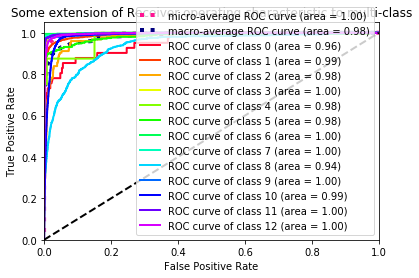

time: 294 ms


In [400]:
from scipy import interp

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(param['num_class'])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(param['num_class']):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= param['num_class']

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

num_colors = param['num_class']
cm = plt.get_cmap('gist_rainbow')

from itertools import cycle
colors = cycle([cm(1.*i/num_colors) for i in range(num_colors)])

lw = 2
for i, color in zip(range(param['num_class']), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [390]:
import matplotlib.pyplot as plt

time: 156 ms


In [391]:
num_colors = param['num_class']
cm = plt.get_cmap('gist_rainbow')

time: 982 µs


In [393]:
[cm(1.*i/num_colors) for i in range(num_colors)]

[(1.0, 0.0, 0.16, 1.0),
 (1.0, 0.2405935347111818, 0.0, 1.0),
 (1.0, 0.6645468998410176, 0.0, 1.0),
 (0.9114997350291467, 1.0, 0.0, 1.0),
 (0.5087440381558028, 1.0, 0.0, 1.0),
 (0.08479067302596743, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.33733923676997696, 1.0),
 (0.0, 1.0, 0.7379295804343246, 1.0),
 (0.0, 0.8386615515771522, 1.0, 1.0),
 (0.0, 0.412404092071611, 1.0, 1.0),
 (0.0, 0.007459505541347444, 1.0, 1.0),
 (0.4187979539641946, 0.0, 1.0, 1.0),
 (0.8450554134697361, 0.0, 1.0, 1.0)]

time: 5.5 ms


time: 2.06 ms


In [396]:
colors

time: 2.95 ms


In [305]:
result_pdf = test_pdf.copy()
result_pdf = result_pdf.reset_index()
result_pdf['check'] = pd.Series(check)

print("==> length of result_pdf = ", result_pdf.shape[0])
print("==> length of 'check' series = ", len(check))

==> length of result_pdf =  21407
==> length of 'check' series =  21407
time: 4.38 ms


In [304]:
result_pdf[-5:]

,index,MAC,category_id,5min_time_bin,pkts,ip_bytes,check
21402,71490,f4:f2:6d:93:51:f1,1.0,4918789,59,3274,1.0
21403,71491,f4:f2:6d:93:51:f1,1.0,4918790,7,15628,5.0
21404,71496,f4:f2:6d:93:51:f1,1.0,4918795,73,41873,1.0
21405,71498,f4:f2:6d:93:51:f1,1.0,4918797,11,28347,5.0
21406,71501,f4:f2:6d:93:51:f1,1.0,4918801,58,3218,1.0


time: 12.6 ms


In [313]:
x = 0
roc_pdf = result_pdf[result_pdf['category_id'] == x][['category_id','check']]

time: 3.49 ms


In [315]:
roc_pdf[-5:]

,category_id,check
14509,0.0,10.0
14510,0.0,1.0
14511,0.0,9.0
14512,0.0,0.0
14513,0.0,0.0


time: 6.46 ms


In [317]:
def make_binary(row):
    true_id = row['category_id']
    pred_id = row['check']
    
    if(true_id == pred_id):
        return [0,0]
    else:
        return [0,1]

time: 1.58 ms


In [326]:
fpr = dict()
tpr = dict()
roc_auc = dict()

time: 1.02 ms


In [327]:
num_classes = int(len(result_pdf.groupby('category_id')['category_id'].nunique()))
for i in range(1):
    calc_roc_pdf = roc_pdf[roc_pdf['category_id'] == i].apply(make_binary, axis=1)
    fpr[i], tpr[i], _ = roc_curve(calc_roc_pdf['category_id'], calc_roc_pdf['check'])
    roc_auc[i] = auc(fpr[i], tpr[i])

time: 15.1 ms


/opt/conda/envs/pygdf_dev/lib/python3.5/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [328]:
fpr

{0: array([0.    , 0.4375, 1.    ])}

time: 2.94 ms


In [329]:
tpr

{0: array([nan, nan, nan])}

time: 2.48 ms


In [330]:
calc_roc_pdf = roc_pdf[roc_pdf['category_id'] == 0].apply(make_binary, axis=1)

time: 10.8 ms


In [331]:
calc_roc_pdf

,category_id,check
14466,0,1
14467,0,1
14468,0,1
14469,0,1
14470,0,0
14471,0,0
14472,0,0
14473,0,1
14474,0,1
14475,0,0


time: 9.06 ms


In [316]:
roc_curve(roc_pdf['category_id'], roc_pdf['check'])

/opt/conda/envs/pygdf_dev/lib/python3.5/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(array([0.        , 0.04166667, 0.0625    , 0.125     , 0.375     ,
        0.4375    , 1.        ]),
 array([nan, nan, nan, nan, nan, nan, nan]),
 array([11., 10.,  9.,  8.,  3.,  1.,  0.], dtype=float32))

time: 5.8 ms


In [293]:
roc_pdf['category_id']

0        1.0
4        1.0
5        1.0
9        1.0
11       1.0
19       1.0
21       1.0
26       1.0
27       1.0
31       1.0
33       1.0
34       1.0
38       1.0
46       1.0
49       1.0
50       1.0
51       1.0
52       1.0
56       1.0
59       1.0
68       1.0
70       1.0
72       1.0
74       1.0
81       1.0
82       1.0
88       1.0
89       1.0
90       1.0
93       1.0
        ... 
71367    1.0
71369    1.0
71373    1.0
71374    1.0
71377    1.0
71383    1.0
71384    1.0
71386    1.0
71391    1.0
71392    1.0
71394    1.0
71397    1.0
71403    1.0
71404    1.0
71405    1.0
71412    1.0
71417    1.0
71425    1.0
71434    1.0
71441    1.0
71447    1.0
71451    1.0
71452    1.0
71468    1.0
71473    1.0
71478    1.0
71483    1.0
71490    1.0
71494    1.0
71500    1.0
Name: category_id, Length: 5956, dtype: float64

time: 7.22 ms
